# Importing all the necessary libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,r2_score
import yfinance as yf


# Load data from Yahoo Finance

In [2]:
ticker = "AAPL"
data=yf.download(ticker, start="2024-01-01", end="2025-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.532074,187.315366,182.792518,186.033057,82488700
2024-01-03,183.150375,184.770652,182.335262,183.120556,58414500
2024-01-04,180.824356,181.997307,179.800504,181.062914,71983600
2024-01-05,180.098694,181.669266,179.094727,180.903872,62303300
2024-01-08,184.452560,184.492330,180.416793,181.003268,59144500


In [4]:
#selecting the 'Close' column for prediction
data = data[['Close']]
data

Price,Close
Ticker,AAPL
Date,
2024-01-02,184.532074
2024-01-03,183.150375
2024-01-04,180.824356
2024-01-05,180.098694
2024-01-08,184.452560
...,...
2024-12-24,257.916443
2024-12-26,258.735504


## 2. Get Ticker Information

In [5]:
# df=yf.Ticker(ticker)
# df.dividends
# df.income_stmt
# df.balancesheet
# df.history(period='1mo')

# Data preprocessing

## check if any missing values

In [6]:

nulldata=data.isna().sum()
nulldata

Price  Ticker
Close  AAPL      0
dtype: int64

## Remove the rows having null values

In [7]:
#drop the rows having null values
data.dropna(inplace=True)
data.head()

Price,Close
Ticker,AAPL
Date,
2024-01-02,184.532074
2024-01-03,183.150375
2024-01-04,180.824356
2024-01-05,180.098694
2024-01-08,184.452560


## Applying MinMaxScaler to the data


In [8]:
minmax=MinMaxScaler()
scaled_data=minmax.fit_transform(data['Close'].values.reshape(-1,1))
# scaled_data = scaler.fit_transform(data[['Close']]) #can also be used


# Create sequences

In [9]:
def create_sequence(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])  # Sequence of time steps
        Y.append(data[i + time_step])    # Target value (next step after the sequence)
    return np.array(X), np.array(Y)
#consider time_step to be 60 
time_step=60
X,Y=create_sequence(scaled_data,time_step)
# X=X.reshape(X.shape[0],X.shape[1],1)   #not required as X is already 3D(samples, time steps, features)

'''
This is best approach to split the data into train and test sets to avoid data leakage. Generally done before scaling the data.

train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
train_data

#defining sequence
def create_sequence(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data) #X_train.shape=2d,y_train.shape=1d
X_test, y_test = create_dataset(test_data)


# resahpping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #X_train.shape  
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) # X_test.shape= 3d (requires input for lstm)


'''
    
    

'\nThis is best approach to split the data into train and test sets to avoid data leakage. Generally done before scaling the data.\n\ntrain_size = int(len(scaled_data) * 0.80)\ntrain_data = scaled_data[:train_size]\ntest_data = scaled_data[train_size:]\ntrain_data\n\n#defining sequence\ndef create_sequence(data, time_step=60):\n    X, y = [], []\n    for i in range(time_step, len(data)):\n        X.append(data[i-time_step:i, 0])\n        y.append(data[i, 0])\n    return np.array(X), np.array(y)\n\nX_train, y_train = create_dataset(train_data) #X_train.shape=2d,y_train.shape=1d\nX_test, y_test = create_dataset(test_data)\n\n\n# resahpping\nX_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #X_train.shape  \nX_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) # X_test.shape= 3d (requires input for lstm)\n\n\n'

In [10]:
X.shape


(192, 60, 1)

In [11]:
Y.shape


(192, 1)

# Train test split

In [12]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=False)
'''Alternatively, you can use the following code to split the data into training and testing sets without shuffling:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

This will ensure that the training and testing sets are sequential and not shuffled.'''


'Alternatively, you can use the following code to split the data into training and testing sets without shuffling:\nsplit = int(0.8 * len(X))\nX_train, X_test = X[:split], X[split:]\ny_train, y_test = y[:split], y[split:]\n\nThis will ensure that the training and testing sets are sequential and not shuffled.'

# Build LSTM for Prediction

In [13]:
# 3. Build Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
'''
Step | Layer | Input Shape | Output Shape | What It Does
1 | Input | (batch_size, seq_length, 1) | (batch_size, seq_length, 1) | Input sequence data (ex: 60 days of stock prices)
2 | LSTM(64, return_sequences=True) | (batch_size, seq_length, 1) | (batch_size, seq_length, 64) | Each timestep is encoded into a 64-feature vector (keeps sequence)
3 | Dropout(0.2) | (batch_size, seq_length, 64) | (batch_size, seq_length, 64) | Randomly drops 20% of outputs per timestep (regularization)
4 | LSTM(64, return_sequences=False) | (batch_size, seq_length, 64) | (batch_size, 64) | Collapses sequence into one final 64-feature vector
5 | Dropout(0.2) | (batch_size, 64) | (batch_size, 64) | Randomly drops 20% of outputs from the 64 features
6 | Dense(32, activation='relu') | (batch_size, 64) | (batch_size, 32) | Fully connects 64 features into 32 features with ReLU activation
7 | Dense(1) | (batch_size, 32) | (batch_size, 1) | Fully connects 32 features into one final predicted value (price)
'''

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


"\nStep | Layer | Input Shape | Output Shape | What It Does\n1 | Input | (batch_size, seq_length, 1) | (batch_size, seq_length, 1) | Input sequence data (ex: 60 days of stock prices)\n2 | LSTM(64, return_sequences=True) | (batch_size, seq_length, 1) | (batch_size, seq_length, 64) | Each timestep is encoded into a 64-feature vector (keeps sequence)\n3 | Dropout(0.2) | (batch_size, seq_length, 64) | (batch_size, seq_length, 64) | Randomly drops 20% of outputs per timestep (regularization)\n4 | LSTM(64, return_sequences=False) | (batch_size, seq_length, 64) | (batch_size, 64) | Collapses sequence into one final 64-feature vector\n5 | Dropout(0.2) | (batch_size, 64) | (batch_size, 64) | Randomly drops 20% of outputs from the 64 features\n6 | Dense(32, activation='relu') | (batch_size, 64) | (batch_size, 32) | Fully connects 64 features into 32 features with ReLU activation\n7 | Dense(1) | (batch_size, 32) | (batch_size, 1) | Fully connects 32 features into one final predicted value (price)

## Compile the model

In [14]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error' ,
    metrics=['mean_absolute_error']
)

## Define callbacks to control training processes automatically

In [15]:
# 4. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

## Training the model

In [16]:
hist=model.fit(X_train,
          Y_train,
          epochs=50,
          validation_data=(X_test,Y_test),
          batch_size=32,
          callbacks=[early_stop, reduce_lr],
          verbose=2)

Epoch 1/50
5/5 - 7s - 1s/step - loss: 0.1791 - mean_absolute_error: 0.3687 - val_loss: 0.1392 - val_mean_absolute_error: 0.3618 - learning_rate: 1.0000e-03
Epoch 2/50
5/5 - 0s - 75ms/step - loss: 0.0251 - mean_absolute_error: 0.1289 - val_loss: 0.0271 - val_mean_absolute_error: 0.1474 - learning_rate: 1.0000e-03
Epoch 3/50
5/5 - 0s - 75ms/step - loss: 0.0185 - mean_absolute_error: 0.1080 - val_loss: 0.0290 - val_mean_absolute_error: 0.1513 - learning_rate: 1.0000e-03
Epoch 4/50
5/5 - 0s - 73ms/step - loss: 0.0163 - mean_absolute_error: 0.1067 - val_loss: 0.0358 - val_mean_absolute_error: 0.1729 - learning_rate: 1.0000e-03
Epoch 5/50
5/5 - 0s - 76ms/step - loss: 0.0107 - mean_absolute_error: 0.0810 - val_loss: 0.0055 - val_mean_absolute_error: 0.0672 - learning_rate: 1.0000e-03
Epoch 6/50
5/5 - 0s - 70ms/step - loss: 0.0100 - mean_absolute_error: 0.0799 - val_loss: 0.0054 - val_mean_absolute_error: 0.0659 - learning_rate: 1.0000e-03
Epoch 7/50
5/5 - 0s - 70ms/step - loss: 0.0083 - mean_

## Plotting training and validation loss


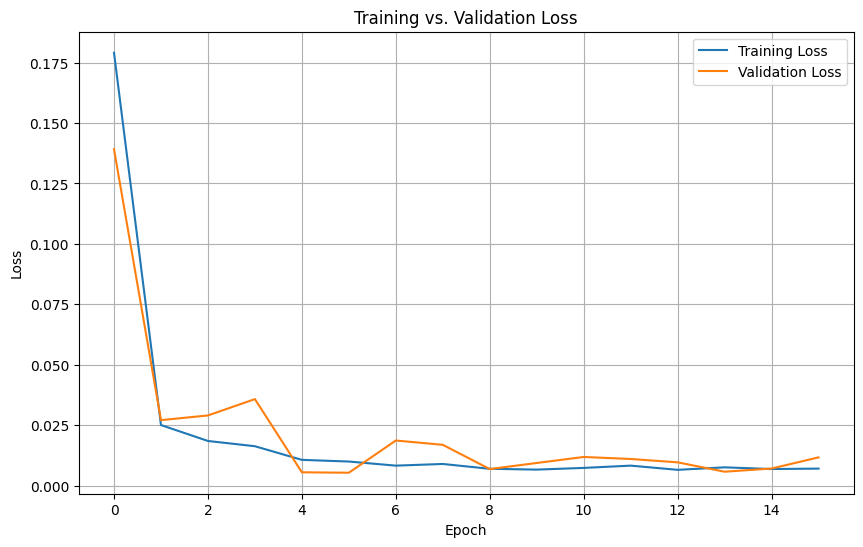

In [17]:
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss,   label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model.evaluate(X_test,Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0052 - mean_absolute_error: 0.0651


[0.0053581297397613525, 0.0659492015838623]

## predictions on test data

In [19]:
Y_pred=model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step


## Inverse transform the predictions and actual data into original scale

In [20]:
# Preprocess the data
actual_data=minmax.inverse_transform(Y_test)
predicted_data=minmax.inverse_transform(Y_pred)#not reshaping the data as it is already in 2D array

In [21]:
predicted_data[:5]


array([[234.04234],
       [233.4849 ],
       [232.90532],
       [232.46819],
       [232.12457]], dtype=float32)

# Evaluate the model

In [22]:
model.evaluate(X_test,Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mean_absolute_error: 0.0651


[0.0053581297397613525, 0.0659492015838623]

## calculating root_mean_squared_error,r2score


In [27]:
r2score=r2_score(actual_data,predicted_data)
print(f"R2 Score: {r2score:.4f}")
root_mean_squared_error_value=root_mean_squared_error(actual_data,predicted_data)
print(f"Mean Squared Error: {root_mean_squared_error_value:.4f}")


R2 Score: 0.6372
Mean Squared Error: 6.9181


# Visualize the results

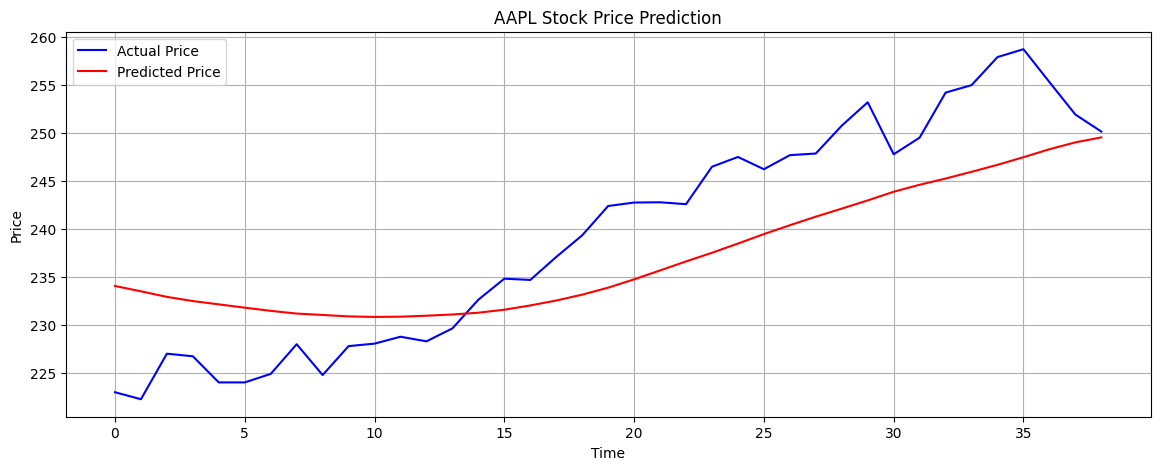

In [24]:
plt.figure(figsize=(14,5))
plt.plot(actual_data, label='Actual Price', color='blue')
plt.plot(predicted_data, label='Predicted Price', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# 7. Predict Unseen Future (Next N Days)

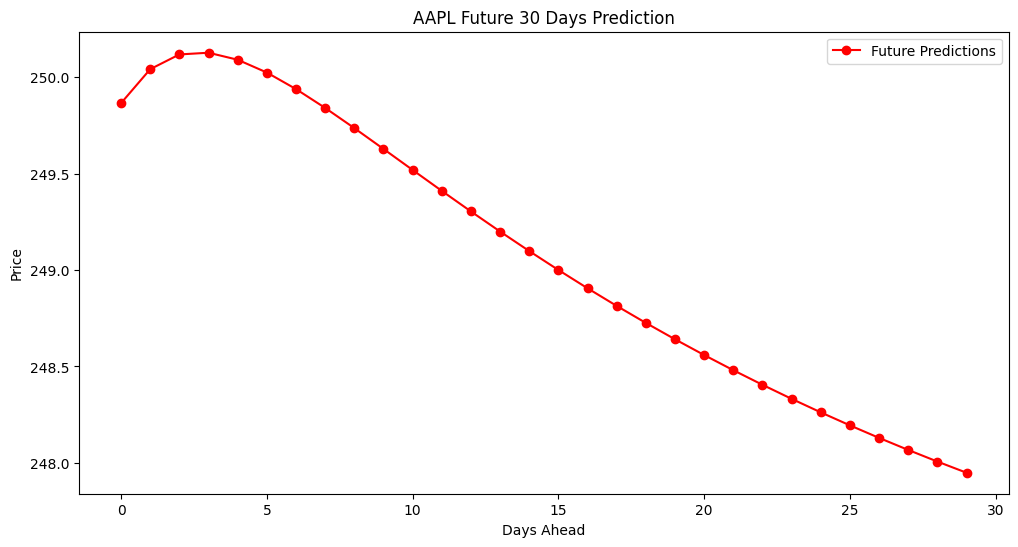

In [25]:
def predict_future(model, last_sequence, n_days):
    predictions = []
    curr_seq = last_sequence.copy()
    for _ in range(n_days):
        pred = model.predict(curr_seq[np.newaxis, :, :], verbose=0)[0, 0] #since model expect 3d (sample,timestep,features) so converting curr_seq(2d) into 3d by adding a new dimension using np.newaxis and takes all rows and all columns
        predictions.append(pred)#here pred is scaled value since we used [0,0] while prediction
        curr_seq = np.append(curr_seq[1:], [[pred]], axis=0)  # slide window, np.append() is a NumPy function used to append values to the end of an array.Here [[pred]] converts scalar value into 2D array which is fit for np.append() function.
    return np.array(predictions)

n_future_days = 30
last_seq = scaled_data[-time_step:]

future_preds_scaled = predict_future(model, last_seq, n_future_days)

# Now correctly reshape for inverse_transform
future_preds = minmax.inverse_transform(future_preds_scaled.reshape(-1, 1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(n_future_days), future_preds, marker='o',color='red' ,label='Future Predictions')
plt.title(f'{ticker} Future {n_future_days} Days Prediction')
plt.xlabel('Days Ahead')
plt.ylabel('Price')
plt.legend()
plt.show()